1. Install Required Libraries

In [ ]:
# Install required libraries
%pip install gym yfinance numpy scikit-learn vaderSentiment praw newsapi-python tweepy matplotlib pandas

In [2]:
%pip install textblob

Note: you may need to restart the kernel to use updated packages.


2. Set Up API Keys

In [2]:
import os

# Set the environment variables directly in your code (if not already set in the environment)
os.environ['REDDIT_CLIENT_ID'] = 'Al6uJ7A7yqueDDlAb_5Blg'
os.environ['REDDIT_CLIENT_SECRET'] = '6Vm1EDNIOjoKs7L70XGd-GHY8OdPYw'
os.environ['REDDIT_USER_AGENT'] = 'StockSentimentApp:v1.0 (by /u/theaadish)'
os.environ['NEWS_API_KEY'] = '66841f746495438e9f59b0b867070b5f'



3. Data Collection (Sentiment Analysis)

In [3]:
import praw
from textblob import TextBlob
from datetime import datetime, timedelta
import requests
import os

# Reddit API credentials
reddit = praw.Reddit(
    client_id=os.getenv('REDDIT_CLIENT_ID'),
    client_secret=os.getenv('REDDIT_CLIENT_SECRET'),
    user_agent=os.getenv('REDDIT_USER_AGENT')
)

# Function to get Reddit sentiment
def get_reddit_sentiment(keyword, days=10):
    # Calculate the date range
    end_date = datetime.today()
    start_date = end_date - timedelta(days=days)
    
    # Fetch posts related to the keyword
    print(f"Fetching Reddit posts for keyword: {keyword}")
    print(f"From: {start_date} To: {end_date}")
    posts = reddit.subreddit('all').search(keyword, sort='new', time_filter='day')

    sentiment_scores = []
    for post in posts:
        post_title = post.title
        analysis = TextBlob(post_title)
        sentiment_scores.append(analysis.sentiment.polarity)

    avg_sentiment = sum(sentiment_scores) / len(sentiment_scores) if sentiment_scores else 0
    return avg_sentiment

# NewsAPI function to get sentiment
def get_news_sentiment(keyword):
    # Use the NewsAPI to fetch articles related to the keyword
    url = f"https://newsapi.org/v2/everything?q={keyword}&apiKey={os.getenv('NEWS_API_KEY')}"
    response = requests.get(url)

    if response.status_code == 200:
        news_data = response.json()
        articles = news_data['articles']
        sentiment_scores = []
        for article in articles:
            article_title = article['title']
            analysis = TextBlob(article_title)
            sentiment_scores.append(analysis.sentiment.polarity)
        
        avg_sentiment = sum(sentiment_scores) / len(sentiment_scores) if sentiment_scores else 0
        return avg_sentiment
    else:
        print(f"Error fetching news: {response.status_code}")
        return 0

# Function to calculate combined sentiment from Reddit and NewsAPI
def get_combined_sentiment(keyword):
    print(f"Fetching sentiment for keyword: {keyword}")

    # Get Reddit Sentiment
    reddit_sentiment = get_reddit_sentiment(keyword)
    print(f"Reddit Sentiment for {keyword}: {reddit_sentiment:.2f}")

    # Get News Sentiment
    news_sentiment = get_news_sentiment(keyword)
    print(f"News Sentiment for {keyword}: {news_sentiment:.2f}")

    # Combine the sentiments (simple average for now)
    combined_sentiment = (reddit_sentiment + news_sentiment) / 2
    print(f"Combined Sentiment for {keyword}: {combined_sentiment:.2f}")

# Example: Get combined sentiment for TSLA
get_combined_sentiment("TSLA")


Fetching sentiment for keyword: TSLA
Fetching Reddit posts for keyword: TSLA
From: 2025-04-23 16:46:43.546008 To: 2025-05-03 16:46:43.546008
Reddit Sentiment for TSLA: 0.05
News Sentiment for TSLA: 0.12
Combined Sentiment for TSLA: 0.08


4. Reinforcement Learning Environment

In [4]:
import gym
import yfinance as yf
import numpy as np
import requests
from sklearn.preprocessing import MinMaxScaler
from textblob import TextBlob
from datetime import datetime, timedelta
import praw
import time
import os
import pandas as pd

# Set environment variables
os.environ['REDDIT_CLIENT_ID'] = 'Al6uJ7A7yqueDDlAb_5Blg'
os.environ['REDDIT_CLIENT_SECRET'] = '6Vm1EDNIOjoKs7L70XGd-GHY8OdPYw'
os.environ['REDDIT_USER_AGENT'] = 'StockSentimentApp:v1.0 (by /u/theaadish)'
os.environ['NEWS_API_KEY'] = '66841f746495438e9f59b0b867070b5f'

# Initialize Reddit API
reddit = praw.Reddit(
    client_id=os.getenv('REDDIT_CLIENT_ID'),
    client_secret=os.getenv('REDDIT_CLIENT_SECRET'),
    user_agent=os.getenv('REDDIT_USER_AGENT')
)

# Get sentiment from Reddit
def get_reddit_sentiment(keyword, days=10):
    posts = reddit.subreddit('all').search(keyword, sort='new', time_filter='day')
    sentiment_scores = [TextBlob(post.title).sentiment.polarity for post in posts]
    return sum(sentiment_scores) / len(sentiment_scores) if sentiment_scores else 0

# Get sentiment from NewsAPI
def get_news_sentiment(keyword):
    url = f"https://newsapi.org/v2/everything?q={keyword}&apiKey={os.getenv('NEWS_API_KEY')}"
    response = requests.get(url)
    if response.status_code == 200:
        articles = response.json().get('articles', [])
        sentiment_scores = [TextBlob(article['title']).sentiment.polarity for article in articles]
        return sum(sentiment_scores) / len(sentiment_scores) if sentiment_scores else 0
    return 0

# Stock trading environment
class StockMarketEnv(gym.Env):
    def __init__(self, tickers, start_date, end_date):
        super(StockMarketEnv, self).__init__()
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date

        self.data = self.download_stock_data()
        self.scaler = MinMaxScaler()

        # ✅ Use 'Close' instead of 'Adj Close'
        if isinstance(self.data.columns, pd.MultiIndex):
            close_prices = self.data['Close'][self.tickers[0]]
        else:
            close_prices = self.data['Close']

        self.data_normalized = self.scaler.fit_transform(close_prices.values.reshape(-1, 1))
        self.close_series = close_prices.reset_index(drop=True)

        self.current_step = 0
        self.done = False

        self.action_space = gym.spaces.Discrete(3)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(3,), dtype=np.float32)

    def download_stock_data(self):
        retries = 5
        for attempt in range(retries):
            try:
                print(f"Downloading data for {self.tickers} from {self.start_date} to {self.end_date}...")
                data = yf.download(self.tickers, start=self.start_date, end=self.end_date, auto_adjust=True)
                if data.empty:
                    raise ValueError("No data retrieved.")
                return data
            except Exception as e:
                print(f"Error: {e}. Retrying...")
                time.sleep(5)
        raise ValueError("Failed to download stock data after multiple retries.")

    def reset(self):
        self.current_step = 0
        self.done = False
        return self._get_state()

    def _get_state(self):
        stock_price = self.data_normalized[self.current_step, 0]
        reddit_sent = get_reddit_sentiment(self.tickers[0])
        news_sent = get_news_sentiment(self.tickers[0])
        return np.array([stock_price, reddit_sent, news_sent], dtype=np.float32)

    def step(self, action):
        if self.done:
            return self.reset()

        reward = 0
        if self.current_step < len(self.close_series) - 1:
            price_diff = self.close_series[self.current_step + 1] - self.close_series[self.current_step]
            if action == 0:  # Buy
                reward = price_diff
            elif action == 2:  # Sell
                reward = -price_diff

        self.current_step += 1
        if self.current_step >= len(self.close_series) - 1:
            self.done = True

        return self._get_state(), reward, self.done, {}

    def render(self):
        pass

# Example Usage
env = StockMarketEnv(tickers=["AAPL"], start_date="2018-01-01", end_date="2023-01-01")
state = env.reset()
action = 0  # Buy
next_state, reward, done, _ = env.step(action)

print(f"Next State: {next_state}")
print(f"Reward: {reward}")
print(f"Done: {done}")


[*********************100%***********************]  1 of 1 completed


Next State: [0.04523537 0.08598406 0.11929654]
Reward: -0.007053375244140625
Done: False


5. Define RL Agent (DQNAgent Class)

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import random
from collections import deque

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_size, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def act(self, state):
        state = np.reshape(state, [1, self.state_size]).astype(np.float32)
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            next_state = np.reshape(next_state, [1, self.state_size])
            if not done:
                target += self.gamma * np.max(self.target_model.predict(next_state, verbose=0))
            target_f = self.model.predict(np.reshape(state, [1, self.state_size]), verbose=0)
            target_f[0][action] = target
            self.model.fit(np.reshape(state, [1, self.state_size]), target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target(self):
        self.target_model.set_weights(self.model.get_weights())

    def save(self, name):
        self.model.save(name)

    def load(self, name):
        self.model = tf.keras.models.load_model(name)
        self.update_target()


6. Training Loop


===== Starting Episode 1/10 =====
✅ Episode 1 complete. Total Reward: -3.07, Epsilon: 0.9655

===== Starting Episode 2/10 =====
✅ Episode 2 complete. Total Reward: 1.29, Epsilon: 0.9183

===== Starting Episode 3/10 =====
✅ Episode 3 complete. Total Reward: 7.12, Epsilon: 0.8734

===== Starting Episode 4/10 =====
✅ Episode 4 complete. Total Reward: 0.12, Epsilon: 0.8307

===== Starting Episode 5/10 =====
✅ Episode 5 complete. Total Reward: -6.23, Epsilon: 0.7901

===== Starting Episode 6/10 =====
✅ Episode 6 complete. Total Reward: -2.68, Epsilon: 0.7515

===== Starting Episode 7/10 =====
✅ Episode 7 complete. Total Reward: 7.36, Epsilon: 0.7147

===== Starting Episode 8/10 =====
✅ Episode 8 complete. Total Reward: -1.31, Epsilon: 0.6798

===== Starting Episode 9/10 =====
✅ Episode 9 complete. Total Reward: 2.78, Epsilon: 0.6466

===== Starting Episode 10/10 =====
✅ Episode 10 complete. Total Reward: 4.26, Epsilon: 0.6149
✅ Model saved as dqn_stock_model.h5
📦 Model loaded for evaluatio

c:\Users\aadis\OneDrive\Desktop\ML\AI portfolio\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


📊 Evaluation total reward: 0.22


C:\Users\aadis\AppData\Local\Temp\ipykernel_2012\1954793151.py:174: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aadis\AppData\Local\Temp\ipykernel_2012\1954793151.py:174: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\aadis\OneDrive\Desktop\ML\AI portfolio\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\aadis\OneDrive\Desktop\ML\AI portfolio\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


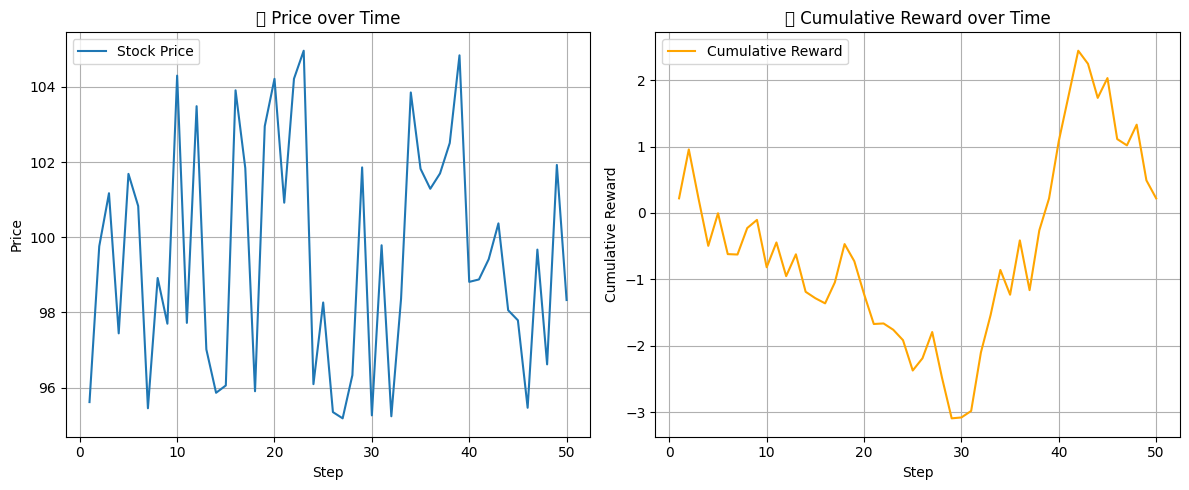

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import random
from collections import deque
import matplotlib.pyplot as plt

# --- Dummy Stock Market Environment ---
class StockMarketEnv:
    def __init__(self, tickers, start_date, end_date):
        self.observation_space = type('', (), {})()
        self.observation_space.sample = lambda: [100.0, 0.0, 0.0]  # [price, reddit_sentiment, news_sentiment]
        self.action_space = type('', (), {})()
        self.action_space.n = 3  # Buy, Hold, Sell
        self.max_steps = 50
        self.current_step = 0
        self.history = []

    def reset(self):
        self.current_step = 0
        self.history = []
        return [100.0, 0.0, 0.0]

    def step(self, action):
        self.current_step += 1
        reward = random.uniform(-1, 1)
        done = self.current_step >= self.max_steps
        price = 100.0 + random.uniform(-5, 5)
        next_state = [price, 0.0, 0.0]
        self.history.append((self.current_step, price, reward))
        return next_state, reward, done, {}

# --- DQN Agent ---
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_size, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def act(self, state):
        state = np.reshape(state, [1, self.state_size]).astype(np.float32)
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            next_state = np.reshape(next_state, [1, self.state_size])
            if not done:
                target += self.gamma * np.max(self.target_model.predict(next_state, verbose=0))
            target_f = self.model.predict(np.reshape(state, [1, self.state_size]), verbose=0)
            target_f[0][action] = target
            self.model.fit(np.reshape(state, [1, self.state_size]), target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target(self):
        self.target_model.set_weights(self.model.get_weights())

    def save(self, name):
        self.model.save(name)

    def load(self, name):
        self.model = tf.keras.models.load_model(name)
        self.update_target()

# --- Initialize Environment and Agent ---
env = StockMarketEnv(tickers=["AAPL"], start_date="2022-01-01", end_date="2023-01-01")
state_size = len(env.observation_space.sample())  # 3
action_size = env.action_space.n  # 3
agent = DQNAgent(state_size, action_size)

# --- Training Loop ---
episodes = 10
batch_size = 16
target_update_freq = 2

for e in range(episodes):
    print(f"\n===== Starting Episode {e+1}/{episodes} =====")
    state = env.reset()
    total_reward = 0
    done = False
    step = 0

    while not done:
        try:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if step % 5 == 0:
                agent.replay(batch_size)
            step += 1
        except Exception as ex:
            print(f"❌ Error at step {step}: {ex}")
            break

    if e % target_update_freq == 0:
        agent.update_target()

    print(f"✅ Episode {e+1} complete. Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.4f}")

# --- Save Model ---
agent.save("dqn_stock_model.h5")
print("✅ Model saved as dqn_stock_model.h5")

# --- Load and Evaluate Model ---
agent.load("dqn_stock_model.h5")
print("📦 Model loaded for evaluation.")

state = env.reset()
done = False
total_reward = 0

while not done:
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    state = next_state
    total_reward += reward

print(f"📊 Evaluation total reward: {total_reward:.2f}")

# --- Visualization ---
if env.history:
    steps, prices, rewards = zip(*env.history)
    cumulative_rewards = np.cumsum(rewards)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(steps, prices, label='Stock Price')
    plt.title("📈 Price over Time")
    plt.xlabel("Step")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(steps, cumulative_rewards, label='Cumulative Reward', color='orange')
    plt.title("💰 Cumulative Reward over Time")
    plt.xlabel("Step")
    plt.ylabel("Cumulative Reward")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No history to plot.")


7. Save and Load Model

In [ ]:
# Save model after training
agent.save("dqn_stock_model.h5")

# Later or in another session, load model:
agent.load("dqn_stock_model.h5")


8. Visualization and Evaluation

In [ ]:
import matplotlib.pyplot as plt

state = env.reset()
done = False
env.history = []
total_reward = 0

while not done:
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    state = next_state
    total_reward += reward

# Extract from env.history for plotting
steps, prices, rewards = zip(*env.history)
cumulative_rewards = np.cumsum(rewards)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(steps, prices, label="Stock Price")
plt.title("Stock Price Over Time")
plt.xlabel("Time Step")
plt.ylabel("Price")

plt.subplot(2, 1, 2)
plt.plot(steps, cumulative_rewards, color="green", label="Cumulative Reward")
plt.title("Cumulative Reward")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Reward")
plt.tight_layout()
plt.show()

print(f"Evaluation Total Reward: {total_reward:.2f}")
